In [1]:
import pandas as pd

bvsp_data = pd.read_csv('^BVSP.csv')
mxx_data = pd.read_csv('^MXX.csv')

bvsp_data_head = bvsp_data.head()
mxx_data_head = mxx_data.head()

# Data Preparation

In [2]:
bvsp_adj = bvsp_data[['Date', 'Adj Close']].rename(columns={'Adj Close': 'BVSP_Adj_Close'})
mxx_adj = mxx_data[['Date', 'Adj Close']].rename(columns={'Adj Close': 'MXX_Adj_Close'})

combined_data = pd.merge(bvsp_adj, mxx_adj, on='Date', how='outer').sort_values(by='Date')
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

# Filling any missing values
combined_data.fillna(method='ffill', inplace=True)
combined_data.fillna(method='bfill', inplace=True)

# Calculate Bollinger Bands for Mean Reverting Signal
window = 20
no_of_std = 2

combined_data['BVSP_Mean'] = combined_data['BVSP_Adj_Close'].rolling(window=window).mean()
combined_data['BVSP_Std'] = combined_data['BVSP_Adj_Close'].rolling(window=window).std()
combined_data['BVSP_Upper_Band'] = combined_data['BVSP_Mean'] + (combined_data['BVSP_Std'] * no_of_std)
combined_data['BVSP_Lower_Band'] = combined_data['BVSP_Mean'] - (combined_data['BVSP_Std'] * no_of_std)

combined_data['MXX_Mean'] = combined_data['MXX_Adj_Close'].rolling(window=window).mean()
combined_data['MXX_Std'] = combined_data['MXX_Adj_Close'].rolling(window=window).std()
combined_data['MXX_Upper_Band'] = combined_data['MXX_Mean'] + (combined_data['MXX_Std'] * no_of_std)
combined_data['MXX_Lower_Band'] = combined_data['MXX_Mean'] - (combined_data['MXX_Std'] * no_of_std)

# Calculate Momentum using a 14-day rate of change
momentum_window = 14
combined_data['BVSP_Momentum'] = combined_data['BVSP_Adj_Close'].pct_change(periods=momentum_window)
combined_data['MXX_Momentum'] = combined_data['MXX_Adj_Close'].pct_change(periods=momentum_window)

combined_data.tail()


,Date,BVSP_Adj_Close,MXX_Adj_Close,BVSP_Mean,BVSP_Std,BVSP_Upper_Band,BVSP_Lower_Band,MXX_Mean,MXX_Std,MXX_Upper_Band,MXX_Lower_Band,BVSP_Momentum,MXX_Momentum
243,2024-03-22,127027.0,57372.761719,128270.85,1309.193214,130889.236428,125652.463572,57372.761719,0.001219,57372.764157,57372.759281,-0.010238,0.0
244,2024-03-25,126931.0,57372.761719,128136.95,1302.057460,130741.064920,125532.835080,57372.761719,0.001219,57372.764157,57372.759281,-0.009110,0.0
245,2024-03-26,126863.0,57372.761719,127895.65,1027.339296,129950.328592,125840.971408,57372.761719,0.001219,57372.764157,57372.759281,-0.015727,0.0
246,2024-03-27,127691.0,57372.761719,127772.45,879.196671,129530.843343,126014.056657,57372.761719,0.001219,57372.764157,57372.759281,-0.005057,0.0
247,2024-03-28,128106.0,57372.761719,127726.75,833.504136,129393.758272,126059.741728,57372.761719,0.001219,57372.764157,57372.759281,0.008145,0.0


In [3]:
def turtle_trading_signals(data):
    signals = []
    for i in range(1, len(data)):
        signal = {}
        # Entry Signals
        if data['Adj Close'][i] > data['20d_High'][i-1]:
            signal['Action'] = 'Buy'
        elif data['Adj Close'][i] < data['20d_Low'][i-1]:
            signal['Action'] = 'Sell'
        
        # Exit Signals
        if signal.get('Action') == 'Buy' and data['Adj Close'][i] < data['20d_Low'][i-1]:
            signal['Exit'] = 'Sell'
        elif signal.get('Action') == 'Sell' and data['Adj Close'][i] > data['20d_High'][i-1]:
            signal['Exit'] = 'Buy'
        
        # Stop Loss and Position Sizing
        if signal.get('Action') == 'Buy':
            signal['Stop Loss'] = data['Adj Close'][i] - 2 * data['ATR'][i]
        elif signal.get('Action') == 'Sell':
            signal['Stop Loss'] = data['Adj Close'][i] + 2 * data['ATR'][i]
        
        signals.append(signal)
    return signals


In [4]:
# Calculate 20-day high and low for entry and exit signals
combined_data['BVSP_20d_High'] = combined_data['BVSP_Adj_Close'].rolling(window=20).max()
combined_data['BVSP_20d_Low'] = combined_data['BVSP_Adj_Close'].rolling(window=20).min()
combined_data['MXX_20d_High'] = combined_data['MXX_Adj_Close'].rolling(window=20).max()
combined_data['MXX_20d_Low'] = combined_data['MXX_Adj_Close'].rolling(window=20).min()

# Calculate the Average True Range (ATR) for risk management
def calculate_atr(data, n=14):
    data['High_Low'] = data['Adj Close'].rolling(window=2).max() - data['Adj Close'].rolling(window=2).min()
    data['High_Close'] = abs(data['Adj Close'].rolling(window=2).max() - data['Adj Close'].shift())
    data['Low_Close'] = abs(data['Adj Close'].rolling(window=2).min() - data['Adj Close'].shift())
    data['TR'] = data[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
    data['ATR'] = data['TR'].rolling(window=n).mean()
    return data['ATR']

combined_data['BVSP_ATR'] = calculate_atr(bvsp_data, n=14)
combined_data['MXX_ATR'] = calculate_atr(mxx_data, n=14)

combined_data[['Date', 'BVSP_Adj_Close', 'BVSP_20d_High', 'BVSP_20d_Low', 'BVSP_ATR', 'MXX_Adj_Close', 'MXX_20d_High', 'MXX_20d_Low', 'MXX_ATR']].tail()


,Date,BVSP_Adj_Close,BVSP_20d_High,BVSP_20d_Low,BVSP_ATR,MXX_Adj_Close,MXX_20d_High,MXX_20d_Low,MXX_ATR
243,2024-03-22,127027.0,131689.0,126124.0,816.285714,57372.761719,57372.761719,57372.761719,436.218192
244,2024-03-25,126931.0,131689.0,126124.0,805.785714,57372.761719,57372.761719,57372.761719,397.322824
245,2024-03-26,126863.0,130155.0,126124.0,754.071429,57372.761719,57372.761719,57372.761719,387.186663
246,2024-03-27,127691.0,129180.0,126124.0,773.928571,57372.761719,57372.761719,57372.761719,360.437500
247,2024-03-28,128106.0,129180.0,126124.0,712.928571,57372.761719,57372.761719,57372.761719,351.964007


# Back-testing

In [5]:
import numpy as np

# Initialize columns for signals and position tracking
combined_data['Position_BVSP'] = 0
combined_data['Position_MXX'] = 0

# Generate signals based on strategy rules
for i in range(1, len(combined_data)):
    # BVSP Signals
    if combined_data.loc[i, 'BVSP_Adj_Close'] > combined_data.loc[i-1, 'BVSP_20d_High']:
        combined_data.loc[i, 'Position_BVSP'] = 1
    elif combined_data.loc[i, 'BVSP_Adj_Close'] < combined_data.loc[i-1, 'BVSP_20d_Low']:
        combined_data.loc[i, 'Position_BVSP'] = -1
    
    # MXX Signals
    if combined_data.loc[i, 'MXX_Adj_Close'] > combined_data.loc[i-1, 'MXX_20d_High']:
        combined_data.loc[i, 'Position_MXX'] = 1
    elif combined_data.loc[i, 'MXX_Adj_Close'] < combined_data.loc[i-1, 'MXX_20d_Low']:
        combined_data.loc[i, 'Position_MXX'] = -1

# Calculate daily returns
combined_data['BVSP_Returns'] = combined_data['BVSP_Adj_Close'].pct_change()
combined_data['MXX_Returns'] = combined_data['MXX_Adj_Close'].pct_change()

# Calculate strategy performance
combined_data['Strategy_BVSP_Returns'] = combined_data['BVSP_Returns'] * combined_data['Position_BVSP'].shift()
combined_data['Strategy_MXX_Returns'] = combined_data['MXX_Returns'] * combined_data['Position_MXX'].shift()

# Calculate cumulative returns 
combined_data['Cumulative_Strategy_BVSP_Returns'] = (1 + combined_data['Strategy_BVSP_Returns']).cumprod() - 1
combined_data['Cumulative_Strategy_MXX_Returns'] = (1 + combined_data['Strategy_MXX_Returns']).cumprod() - 1

# Performance Metrics
total_return_bvsp = combined_data['Cumulative_Strategy_BVSP_Returns'].iloc[-1]
total_return_mxx = combined_data['Cumulative_Strategy_MXX_Returns'].iloc[-1]

# Calculate annualized return 
annualized_return_bvsp = (1 + total_return_bvsp) ** (252 / len(combined_data)) - 1
annualized_return_mxx = (1 + total_return_mxx) ** (252 / len(combined_data)) - 1

# Calculate the Sharpe ratio 
sharpe_ratio_bvsp = combined_data['Strategy_BVSP_Returns'].mean() / combined_data['Strategy_BVSP_Returns'].std() * np.sqrt(252)
sharpe_ratio_mxx = combined_data['Strategy_MXX_Returns'].mean() / combined_data['Strategy_MXX_Returns'].std() * np.sqrt(252)

(total_return_bvsp, annualized_return_bvsp, sharpe_ratio_bvsp,
 total_return_mxx, annualized_return_mxx, sharpe_ratio_mxx)


(-0.022055868151422353,
 -0.0021955874704082667,
 -0.10320843003137456,
 0.058726183964814105,
 0.0056399163513241035,
 0.11143822544892096)

# Visualizations

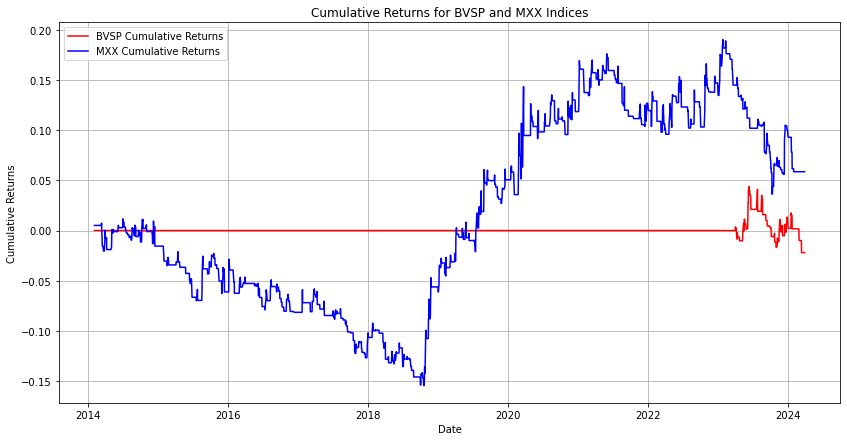

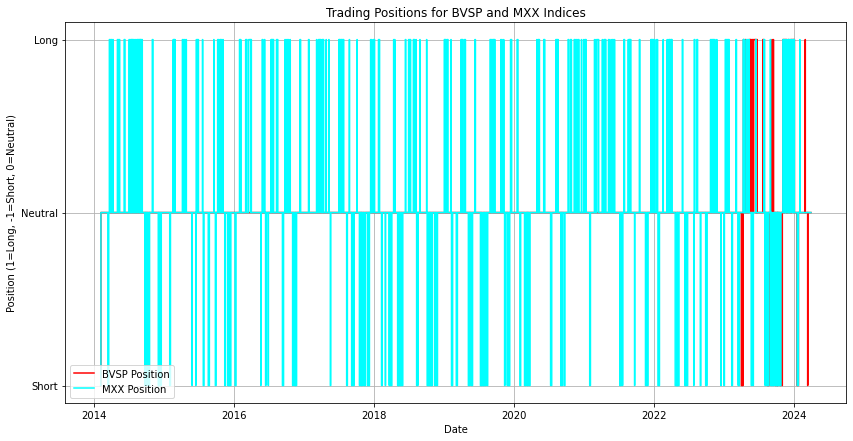

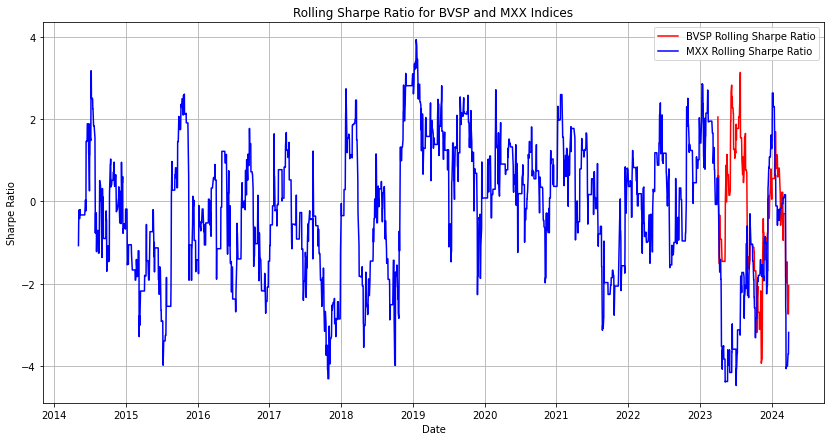

In [16]:
import matplotlib.pyplot as plt

# Plot Cumulative Returns for both BVSP and MXX
plt.figure(figsize=(14, 7))
plt.plot(combined_data['Date'], combined_data['Cumulative_Strategy_BVSP_Returns'], label='BVSP Cumulative Returns', color='r')
plt.plot(combined_data['Date'], combined_data['Cumulative_Strategy_MXX_Returns'], label='MXX Cumulative Returns', color='b')
plt.title('Cumulative Returns for BVSP and MXX Indices')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Plot Positions for BVSP and MXX
plt.figure(figsize=(14, 7))
plt.plot(combined_data['Date'], combined_data['Position_BVSP'], label='BVSP Position', drawstyle='steps-post', color='r')
plt.plot(combined_data['Date'], combined_data['Position_MXX'], label='MXX Position', drawstyle='steps-post', color='cyan')
plt.title('Trading Positions for BVSP and MXX Indices')
plt.xlabel('Date')
plt.ylabel('Position (1=Long, -1=Short, 0=Neutral)')
plt.yticks([-1, 0, 1], ['Short', 'Neutral', 'Long'])
plt.legend()
plt.grid(True)
plt.show()

# Calculate and Plot Rolling Sharpe Ratio
rolling_window = 60
combined_data['Rolling_Sharpe_BVSP'] = (combined_data['Strategy_BVSP_Returns'].rolling(window=rolling_window).mean() / 
                                        combined_data['Strategy_BVSP_Returns'].rolling(window=rolling_window).std() * np.sqrt(252))
combined_data['Rolling_Sharpe_MXX'] = (combined_data['Strategy_MXX_Returns'].rolling(window=rolling_window).mean() / 
                                       combined_data['Strategy_MXX_Returns'].rolling(window=rolling_window).std() * np.sqrt(252))

plt.figure(figsize=(14, 7))
plt.plot(combined_data['Date'], combined_data['Rolling_Sharpe_BVSP'], label='BVSP Rolling Sharpe Ratio', color='r')
plt.plot(combined_data['Date'], combined_data['Rolling_Sharpe_MXX'], label='MXX Rolling Sharpe Ratio', color="b")
plt.title('Rolling Sharpe Ratio for BVSP and MXX Indices')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.show()
